# Pedro e o Lobo: Ambiente Realista

Na nossa situação, Pedro conseguia se movimentar quase sem se cansar ou sentir fome. Em um mundo mais realista, ele precisaria sentar e descansar de vez em quando, além de se alimentar. Vamos tornar nosso mundo mais realista implementando as seguintes regras:

1. Ao se mover de um lugar para outro, Pedro perde **energia** e ganha um pouco de **fadiga**.
2. Pedro pode recuperar energia comendo maçãs.
3. Pedro pode se livrar da fadiga descansando sob uma árvore ou na grama (ou seja, caminhando para uma localização no tabuleiro que tenha uma árvore ou grama - campo verde).
4. Pedro precisa encontrar e matar o lobo.
5. Para matar o lobo, Pedro precisa ter certos níveis de energia e fadiga; caso contrário, ele perde a batalha.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

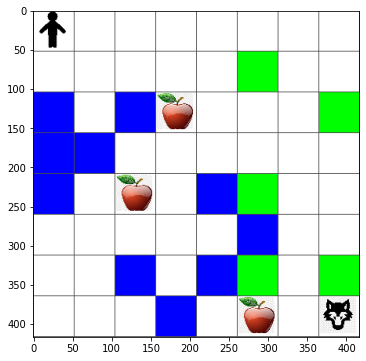

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Definindo estado

Nas novas regras do jogo, precisamos acompanhar a energia e o cansaço em cada estado do tabuleiro. Assim, vamos criar um objeto `state` que irá conter todas as informações necessárias sobre o estado atual do problema, incluindo o estado do tabuleiro, os níveis atuais de energia e cansaço, e se podemos derrotar o lobo enquanto estamos no estado terminal:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Função de Recompensa

### Introdução

A função de recompensa é um componente essencial para treinar um modelo de aprendizado por reforço. Ela define como o agente deve ser recompensado ou penalizado com base em suas ações e estados no ambiente. Projetar uma boa função de recompensa é crucial para garantir que o agente aprenda o comportamento desejado.

### Diretrizes para Criar uma Função de Recompensa

- **Clareza**: Certifique-se de que a função de recompensa seja fácil de entender e implementar. Recompensas complexas podem dificultar o aprendizado do agente.
- **Consistência**: A recompensa deve ser consistente com os objetivos do problema. Evite recompensas que incentivem comportamentos indesejados.
- **Escalabilidade**: A função de recompensa deve funcionar bem em diferentes escalas e cenários do ambiente.

### Exemplos de Funções de Recompensa

#### Exemplo 1: Navegação

Se o objetivo do agente é alcançar um destino específico, você pode definir a recompensa da seguinte forma:

- Recompensa positiva ao alcançar o destino.
- Penalidade por cada passo dado para incentivar trajetórias mais curtas.
- Penalidade adicional por colisões ou ações inválidas.

#### Exemplo 2: Controle de Recursos

Em um cenário onde o agente deve gerenciar recursos, a função de recompensa pode incluir:

- Recompensa por maximizar a utilização eficiente dos recursos.
- Penalidade por desperdício ou uso excessivo.
- Recompensa adicional por atingir metas específicas dentro de um limite de tempo.

### Boas Práticas

- **Teste e Ajuste**: Experimente diferentes configurações de recompensa para encontrar o equilíbrio ideal.
- **Evite Recompensas Excessivas**: Recompensas muito altas podem levar o agente a explorar menos o ambiente.
- **Monitore o Comportamento**: Observe como o agente responde à função de recompensa e ajuste conforme necessário.

### Conclusão

Uma função de recompensa bem projetada é fundamental para o sucesso do aprendizado por reforço. Dedique tempo para entender os objetivos do problema e crie uma função que incentive o comportamento desejado.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Algoritmo Q-Learning

O algoritmo de aprendizado em si permanece praticamente inalterado, apenas usamos `state` em vez de apenas a posição do tabuleiro.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

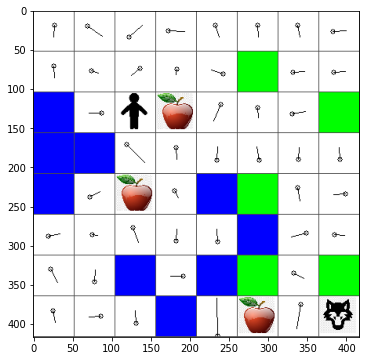

In [11]:
m.plot(Q)

## Resultados

Vamos ver se conseguimos treinar Peter para enfrentar o lobo!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Agora vemos muito menos casos de afogamento, mas Peter ainda não consegue matar o lobo sempre. Tente experimentar e veja se consegue melhorar esse resultado ajustando os hiperparâmetros.


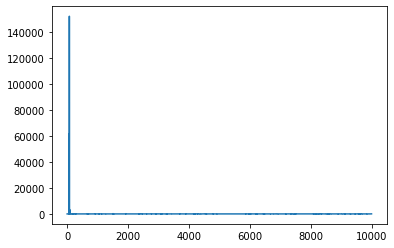

In [13]:
plt.plot(lpath)


---

**Aviso Legal**:  
Este documento foi traduzido utilizando o serviço de tradução por IA [Co-op Translator](https://github.com/Azure/co-op-translator). Embora nos esforcemos para garantir a precisão, esteja ciente de que traduções automatizadas podem conter erros ou imprecisões. O documento original em seu idioma nativo deve ser considerado a fonte autoritativa. Para informações críticas, recomenda-se a tradução profissional realizada por humanos. Não nos responsabilizamos por quaisquer mal-entendidos ou interpretações equivocadas decorrentes do uso desta tradução.
